In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.autograd import grad
from sklearn.preprocessing import StandardScaler

In [2]:
# -----------------------------
# 0. 讀資料 + 標準化（沿用你的做法）
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data = pd.read_csv("data.csv")
a0 = data["a"].iloc[0]
data = data[np.isclose(data["a"], a0)]
print("using fixed a =", a0, "N =", len(data))
data = data.rename(columns={"x": "xp"})  # 如果原本欄位叫 x

X = data[['a', 'm', 'V0', 'n', 'xp']].values  # (N,5)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(
    X_scaled, dtype=torch.float32, device=device, requires_grad=True
)

# 取出 scaler 的 mean / std（用來把 scaled 的導數換回物理座標）
mean = torch.tensor(scaler.mean_, dtype=torch.float32, device=device)     # (5,)
std  = torch.tensor(scaler.scale_, dtype=torch.float32, device=device)    # (5,)

IDX_A = 0
IDX_X = 4

Using device: cuda
using fixed a = 8e-09 N = 388150


In [3]:
# -----------------------------
# 1. 模型：不要再乘 (1-x^2)
# -----------------------------
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
        )

    def forward(self, Xs):
        # Xs: scaled input (N,5)
        return self.net(Xs)

model = PINN().to(device)

In [4]:
# -----------------------------
# 2. 工具：從 batch 的 Xs 生成兩個邊界點（不動資料源頭，但可額外生成 collocation）
#    物理邊界：x = ± a/2
# -----------------------------
def make_boundary_points(Xs):
    """
    Xs: scaled (N,5)
    return: X_left_scaled, X_right_scaled  (N,5), (N,5)
    """
    # 先把 a 從 scaled 還原成物理值
    a_scaled = Xs[:, IDX_A:IDX_A+1]                  # (N,1)
    a_phys = a_scaled * std[IDX_A] + mean[IDX_A]     # (N,1)

    x_left_phys = -0.5 * a_phys
    x_right_phys = 0.5 * a_phys

    # 把邊界 x 再轉回 scaled，塞回 input
    x_left_scaled = (x_left_phys - mean[IDX_X]) / std[IDX_X]
    x_right_scaled = (x_right_phys - mean[IDX_X]) / std[IDX_X]

    X_left = Xs.clone()
    X_right = Xs.clone()
    X_left[:, IDX_X:IDX_X+1] = x_left_scaled
    X_right[:, IDX_X:IDX_X+1] = x_right_scaled

    return X_left, X_right

In [5]:
# -----------------------------
# 3. Eigen-PINN Loss（Rayleigh quotient）
#    E(psi) = ∫|dψ/dx|^2 dx / ∫|ψ|^2 dx
#    + 邊界懲罰 ψ(±a/2)=0
# -----------------------------
def eigen_loss(model, Xs, lambda_bc=50.0, eps=1e-12):
    """
    Xs: scaled input with requires_grad=True
    """
    psi = model(Xs)  # (N,1)

    # 對 scaled x 求導：dψ/dx_scaled
    dpsi_dXs = grad(
        outputs=psi,
        inputs=Xs,
        grad_outputs=torch.ones_like(psi),
        create_graph=True,
        retain_graph=True,
    )[0]  # (N,5)

    dpsi_dx_scaled = dpsi_dXs[:, IDX_X:IDX_X+1]  # (N,1)

    # 換回物理座標：x_phys = x_scaled * std_x + mean_x
    # => d/dx_phys = (1/std_x) d/dx_scaled
    dpsi_dx = dpsi_dx_scaled / std[IDX_X]

    # 近似積分：用 mean 當作 ∫(...)dx 的 proxy（你的取樣若大致均勻就能用）
    T = torch.mean(dpsi_dx**2)          # 動能項
    N = torch.mean(psi**2)              # 正規化項

    rayleigh = T / (N + eps)            # 這裡讓 ψ=0 直接變成超大損失

    # 邊界條件（額外生成兩個邊界點）
    X_left, X_right = make_boundary_points(Xs)
    psi_left = model(X_left)
    psi_right = model(X_right)
    bc = torch.mean(psi_left**2) + torch.mean(psi_right**2)

    loss = rayleigh + lambda_bc * bc
    return loss, rayleigh.detach(), N.detach()



In [6]:
# -----------------------------
# 4. 訓練
# -----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5000
for ep in range(1, epochs + 1):
    optimizer.zero_grad(set_to_none=True)

    loss, rayleigh_val, norm_val = eigen_loss(model, X_tensor, lambda_bc=50.0)
    loss.backward()
    optimizer.step()

    if ep % 200 == 0 or ep == 1:
        # Rayleigh quotient 本身就是 E 的估計（在 V=0 的純井模型下）
        print(f"ep={ep:5d} loss={loss.item():.6e}  E≈{rayleigh_val.item():.6e}  <psi^2>={norm_val.item():.6e}")

C:\Users\Desmond\anaconda3\envs\torch_cuda121\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


ep=    1 loss=4.997171e+13  E≈4.997171e+13  <psi^2>=7.519753e-03
ep=  200 loss=2.161564e+11  E≈2.161564e+11  <psi^2>=1.286839e-01
ep=  400 loss=7.478755e+10  E≈7.478755e+10  <psi^2>=1.216876e-01
ep=  600 loss=4.952665e+10  E≈4.952665e+10  <psi^2>=1.227426e-01
ep=  800 loss=3.592418e+10  E≈3.592418e+10  <psi^2>=1.239902e-01
ep= 1000 loss=2.715499e+10  E≈2.715499e+10  <psi^2>=1.249860e-01
ep= 1200 loss=2.101910e+10  E≈2.101910e+10  <psi^2>=1.256747e-01
ep= 1400 loss=1.655029e+10  E≈1.655029e+10  <psi^2>=1.261048e-01
ep= 1600 loss=1.324817e+10  E≈1.324817e+10  <psi^2>=1.263843e-01
ep= 1800 loss=1.078182e+10  E≈1.078182e+10  <psi^2>=1.266075e-01
ep= 2000 loss=8.897923e+09  E≈8.897923e+09  <psi^2>=1.268145e-01
ep= 2200 loss=7.422947e+09  E≈7.422947e+09  <psi^2>=1.270132e-01
ep= 2400 loss=6.247011e+09  E≈6.247011e+09  <psi^2>=1.272093e-01
ep= 2600 loss=5.298203e+09  E≈5.298203e+09  <psi^2>=1.274149e-01
ep= 2800 loss=4.526544e+09  E≈4.526544e+09  <psi^2>=1.276458e-01
ep= 3000 loss=3.895201e+0

In [8]:
# -----------------------------
# 5. 推論：取 ψ 與 E
# -----------------------------
with torch.no_grad():
    psi_pred = model(X_tensor).detach().cpu().numpy()

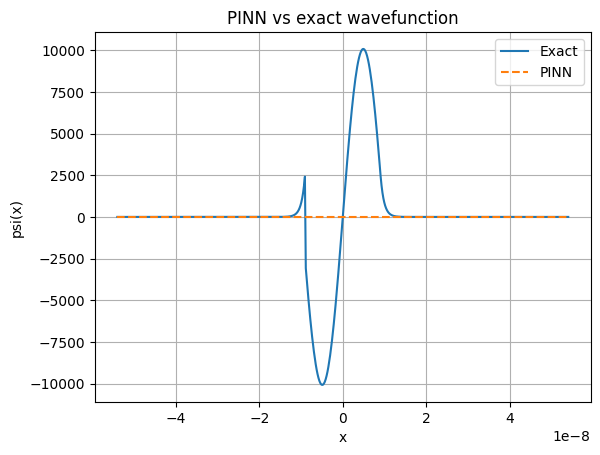

In [19]:
import matplotlib.pyplot as plt
from data import find_bound_states, compute_wavefunction
model.eval()

# ---------- 固定一組物理參數 ----------
a  = 1.80e-08
m  = 1.30e-30
V0 = 6.41e-21
n  = 2
# 1. 找 bound state
states = find_bound_states(a, m, V0)
parity, k, E = states[n-1]
# 2. 用 solver 生 ψ(x)
xs, xp, psi_raw, psi_norm = compute_wavefunction(
    a=a,
    m=m,
    V0=V0,
    parity=parity,
    k=k,
    E=E,
    num_points=501
)
x_grid = xs

x_phys = xs              # 用 exact 的 x
Nx = len(xs)

X_test = np.column_stack([
    np.full(Nx, a),
    np.full(Nx, m),
    np.full(Nx, V0),
    np.full(Nx, n),
    x_phys
])

# 用「同一個 scaler」轉成 scaled
X_test_scaled = scaler.transform(X_test)

X_test_tensor = torch.tensor(
    X_test_scaled,
    dtype=torch.float32,
    device=device,
    requires_grad=True
)
# ---------- PINN 預測 ----------
with torch.no_grad():
    psi_pinn = model(X_test_tensor).cpu().numpy().flatten()

# ---------- exact 解（無限深方井示例） ----------
k = n0 * np.pi / a0
psi_exact = np.sin(k * (x_phys + a0/2))

# ---------- 正規化（只比 shape） ----------
psi_pinn /= np.max(np.abs(psi_pinn))
psi_exact /= np.max(np.abs(psi_exact))

# ---------- 繪圖 ----------
plt.plot(x_grid, psi_norm, label="Exact")
plt.plot(x_grid, psi_pinn, "--", label="PINN")
plt.xlabel("x")
plt.ylabel("psi(x)")
plt.legend()
plt.title("PINN vs exact wavefunction")
plt.grid(True)
plt.show()
